In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
import requests
from PIL import Image
from io import BytesIO
from zipfile import ZipFile
import cv2
import pandas as pd
import numpy as np
import os

In [7]:
translate = {"cane": "Dog", "cavallo": "Horse", "elefante": "Elephant", "farfalla": "Butterfly", "gallina": "Chicken", "gatto": "Cat", "mucca": "Cow", "pecora": "Sheep", "scoiattolo": "Squirrel", "ragno": "Spider"}

In [9]:
from zipfile import ZipFile
file_name = "/content/archive.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [14]:
print(os.listdir("raw-img/"))
#Extract data from kaggle dataset
animalfolders = os.listdir("raw-img/")
f1 = []
f2 = [] 
t1 = []
t2 = []
#Go through each directory and obtain all 10 animal folders
for i, directory in enumerate(animalfolders):
    filenames = os.listdir("raw-img/" + directory);
    count = 0
    for file in filenames:
        if count < 20000:
            f1.append("raw-img/" + directory + "/" + file)
            t1.append(translate[directory])
        else:
            f2.append("raw-img/" + directory + "/" + file)
            t2.append(translate[directory])
        count += 1
df = pd.DataFrame({'Filepath':f1, 'Target':t1})
dft = pd.DataFrame({'Filepath':f2, 'Target':t2})

#Takes data and puts it into a train, test, and validation split with 80/10/10 split
train, rest = train_test_split(df, test_size=0.2, random_state = 0)
valid, test = train_test_split(rest, test_size=0.5, random_state = 0)

['pecora', 'gallina', 'ragno', 'gatto', 'scoiattolo', 'mucca', 'cavallo', 'elefante', 'cane', 'farfalla']


In [15]:
#Utilize ImageDataGenerator in order to generate batches of image data with augmentation
animaldata = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        samplewise_center = True,
        )

datagen_test = ImageDataGenerator(rescale=1./255, samplewise_center = True)
#Takes data and moves it into a flow set
train_data = animaldata.flow_from_dataframe(train, x_col = 'Filepath', y_col = 'Target', target_size=(224, 224), interpolation = 'lanczos', validate_filenames = False)
test_data = animaldata.flow_from_dataframe(test, x_col = 'Filepath', y_col = 'Target', target_size=(224, 224), interpolation = 'lanczos', validate_filenames = False)
valid_data = animaldata.flow_from_dataframe(valid, x_col = 'Filepath', y_col = 'Target', target_size=(224,224), interpolation = 'lanczos', validate_filenames = False)

Found 20943 non-validated image filenames belonging to 10 classes.
Found 2618 non-validated image filenames belonging to 10 classes.
Found 2618 non-validated image filenames belonging to 10 classes.


In [20]:
# Building the CNN model
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units=256,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=10, activation="softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(lr=1e-3), metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 28, 28, 256)     

In [21]:
# Fitting the model to data
output = model.fit(train_data, epochs = 10, validation_data = valid_data, batch_size=64)

Epoch 1/10
655/655 [==============================] - 333s 507ms/step - loss: 1.9295 - accuracy: 0.3217 - val_loss: 1.5628 - val_accuracy: 0.4576
Epoch 2/10
655/655 [==============================] - 330s 504ms/step - loss: 1.4445 - accuracy: 0.5037 - val_loss: 1.3439 - val_accuracy: 0.5355
Epoch 3/10
655/655 [==============================] - 332s 507ms/step - loss: 1.2424 - accuracy: 0.5714 - val_loss: 1.1228 - val_accuracy: 0.6146
Epoch 4/10
655/655 [==============================] - 326s 498ms/step - loss: 1.1275 - accuracy: 0.6105 - val_loss: 1.0418 - val_accuracy: 0.6356
Epoch 5/10
655/655 [==============================] - 328s 501ms/step - loss: 1.0471 - accuracy: 0.6451 - val_loss: 0.9935 - val_accuracy: 0.6650
Epoch 6/10
655/655 [==============================] - 332s 507ms/step - loss: 0.9963 - accuracy: 0.6596 - val_loss: 0.9768 - val_accuracy: 0.6662
Epoch 7/10
655/655 [==============================] - 331s 505ms/step - loss: 0.9505 - accuracy: 0.6757 - val_loss: 0.9029 -

In [22]:
probabilities = model.predict(test_data)

82/82 [==============================] - 36s 440ms/step


[1.5628386735916138, 1.343948483467102, 1.1227824687957764, 1.0418307781219482, 0.9935117959976196, 0.9767757654190063, 0.9028790593147278, 0.8729721903800964, 0.8292688727378845, 0.8024240136146545]
[0.4576012194156647, 0.5355232954025269, 0.6145913004875183, 0.635599672794342, 0.665011465549469, 0.6661573648452759, 0.6913674473762512, 0.7085561752319336, 0.7223070859909058, 0.7333842515945435]


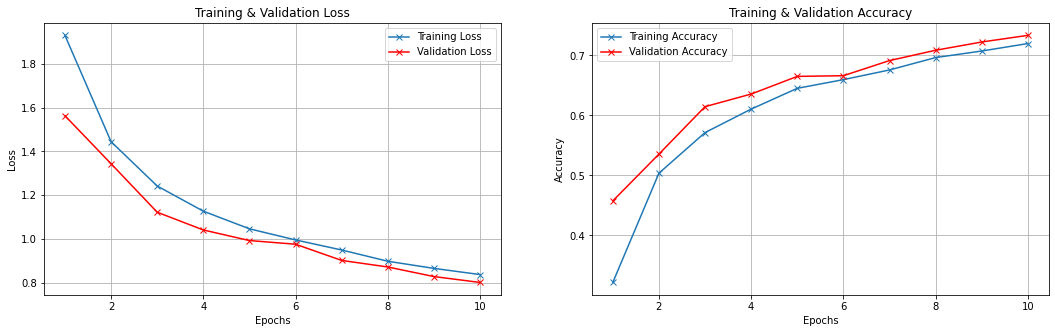

In [23]:
#Graph the validation and training loss/accuracy
loss_vals = output.history['loss']
val_loss_vals = output.history['val_loss']
epochs = range(1, len(output.history['accuracy'])+1)
print(val_loss_vals)

f, graphs = plt.subplots(nrows=1,ncols=2,figsize=(18,5))
    
graphs[0].plot(epochs, loss_vals,  marker='x', label='Training Loss')
graphs[0].plot(epochs, val_loss_vals, marker='x', color = 'red', label='Validation Loss')
graphs[0].set_title('Training & Validation Loss')
graphs[0].set_xlabel('Epochs')
graphs[0].set_ylabel('Loss')
graphs[0].legend(loc='best')
graphs[0].grid(True)

acc_vals = output.history['accuracy']
val_acc_vals = output.history['val_accuracy']
print(val_acc_vals)
graphs[1].plot(epochs, acc_vals, marker='x', label='Training Accuracy')
graphs[1].plot(epochs, val_acc_vals, marker='x', color = 'red', label='Validation Accuracy')
graphs[1].set_title('Training & Validation Accuracy')
graphs[1].set_xlabel('Epochs')
graphs[1].set_ylabel('Accuracy')
graphs[1].legend(loc='best')
graphs[1].grid(True)

plt.show()
plt.close()

In [27]:
test2_flow = datagen_test.flow_from_dataframe(dft, x_col = 'Filepath', y_col = 'Target', target_size=(224, 224), interpolation = 'lanczos', validate_filenames = False)
score = model.evaluate(test2_flow)

Found 0 non-validated image filenames belonging to 0 classes.


ValueError: ignored